In [1]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score


# Nouvelle section

# Defining the model 



*   Je vais  utiliser un dataset aribtraire, exemple : Flower dataset dans Kaggle après on change ça avec notre propore dataset 

*   Ajout de pooling pour réduire la dimension 
*   Utilisation d'un VGG au lieu d'un Resnet 
*   Réduire les dimesnions avec un PCA 
*   application de Kmeans pour culstering










In [2]:
model = VGG16(include_top=True,weights='imagenet',input_shape=(224,224,3),pooling='max')

553476096/553467096 [==============================] - 7s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data


In [7]:
base_dir = "/content/drive/My Drive/flowers"

In [8]:
flowers = []

list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(base_dir, x)),
                        os.listdir(base_dir) ) )
for file in list_of_files : 
  if file.endswith('.png'):
    flowers.append(file)

In [9]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

# Data Preprocessing

In [10]:
import os
os.chdir(base_dir)

img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


(224, 224, 3)


In [11]:
# reshaping the images 
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [12]:

def get_features(file, model):
    # get l'image  224x224 
    img = load_img(file, target_size=(224,224))
    # convertir l'image en numpy
    img = np.array(img) 
    # batch_size = 1, taille = 224x224 , channel = 3
    reshaped_img = img.reshape(1,224,224,3) 
    # passage vers le modele
    imgx = preprocess_input(reshaped_img)
    # get le vecteur de feature
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [13]:
# boucle sur l'ensemble des images

data = {}

for flower in flowers:
  feat = get_features(flower,model)
  data[flower] = feat

filenames = np.array(list(data.keys()))

# liste des features
feat = np.array(list(data.values()))
feat.shape



(210, 1, 4096)

In [14]:
feat = feat.reshape(-1,4096)
feat.shape

(210, 4096)

# PCA

In [15]:
#application de PCA
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

# Kmeans 




In [16]:
kmeans = KMeans(n_clusters=10,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=10)

In [17]:
kmeans.labels_


array([7, 7, 1, 7, 7, 2, 6, 2, 2, 7, 6, 7, 7, 8, 1, 2, 7, 7, 6, 6, 1, 3,
       8, 1, 6, 8, 1, 6, 1, 7, 5, 8, 6, 6, 9, 2, 6, 7, 1, 2, 5, 2, 8, 7,
       2, 3, 1, 7, 2, 2, 4, 3, 8, 5, 7, 8, 6, 7, 6, 2, 1, 2, 8, 7, 7, 6,
       7, 2, 1, 3, 6, 8, 5, 4, 6, 7, 8, 6, 2, 9, 2, 3, 9, 5, 2, 6, 1, 3,
       8, 3, 8, 4, 6, 1, 4, 6, 7, 5, 2, 5, 2, 1, 3, 6, 5, 1, 2, 6, 2, 7,
       6, 3, 1, 5, 6, 7, 2, 8, 7, 7, 6, 1, 3, 6, 2, 7, 1, 7, 2, 8, 6, 1,
       2, 3, 3, 2, 7, 8, 1, 3, 5, 3, 7, 6, 1, 8, 7, 3, 4, 4, 1, 3, 8, 6,
       5, 5, 4, 6, 4, 7, 6, 5, 4, 1, 2, 0, 8, 4, 5, 6, 5, 4, 4, 5, 2, 6,
       2, 3, 1, 1, 7, 6, 2, 1, 7, 7, 5, 2, 4, 1, 3, 8, 2, 6, 2, 9, 8, 6,
       1, 3, 4, 5, 6, 5, 3, 4, 7, 3, 7, 4], dtype=int32)

In [19]:
filenames

array(['0001.png', '0002.png', '0003.png', '0004.png', '0005.png',
       '0006.png', '0007.png', '0008.png', '0009.png', '0010.png',
       '0011.png', '0012.png', '0013.png', '0014.png', '0015.png',
       '0016.png', '0017.png', '0018.png', '0019.png', '0020.png',
       '0021.png', '0022.png', '0023.png', '0024.png', '0025.png',
       '0026.png', '0027.png', '0028.png', '0029.png', '0030.png',
       '0031.png', '0032.png', '0033.png', '0034.png', '0035.png',
       '0036.png', '0037.png', '0038.png', '0039.png', '0040.png',
       '0041.png', '0042.png', '0043.png', '0044.png', '0045.png',
       '0046.png', '0047.png', '0048.png', '0049.png', '0050.png',
       '0051.png', '0052.png', '0053.png', '0054.png', '0055.png',
       '0056.png', '0057.png', '0058.png', '0059.png', '0060.png',
       '0061.png', '0062.png', '0063.png', '0064.png', '0065.png',
       '0066.png', '0067.png', '0068.png', '0069.png', '0070.png',
       '0071.png', '0072.png', '0073.png', '0074.png', '0075.p

In [20]:

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [21]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    # Affichage d'un ensemble de 30
    
    # Afficher chaque image dans son cluster 
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

['0166.png']

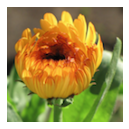

In [22]:
view_cluster(0)
len(groups[0])
groups[0]

['0035.png', '0080.png', '0083.png', '0196.png']

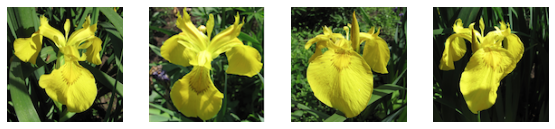

In [23]:
view_cluster(9)
groups[9]

['0022.png',
 '0046.png',
 '0052.png',
 '0070.png',
 '0082.png',
 '0088.png',
 '0090.png',
 '0103.png',
 '0112.png',
 '0123.png',
 '0134.png',
 '0135.png',
 '0140.png',
 '0142.png',
 '0148.png',
 '0152.png',
 '0178.png',
 '0191.png',
 '0200.png',
 '0205.png',
 '0208.png']

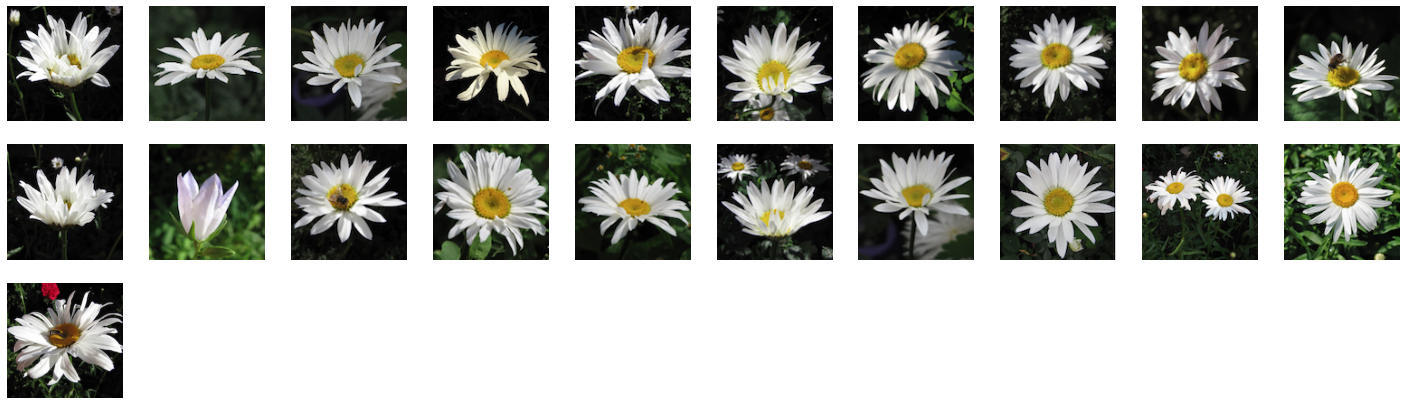

In [24]:
view_cluster(3)
groups[3]

In [25]:
groups[0][0]

'0166.png'

In [26]:
x.shape

(210, 150)

In [27]:
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
y_test = np.array(label)
accuracy_score(kmeans.labels_,y_test)*100



3.3333333333333335

In [28]:
filename = df['file'].tolist()
filename

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [29]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [30]:
print(kmeans.labels_)
print(df['label'].tolist())

[7 7 1 7 7 2 6 2 2 7 6 7 7 8 1 2 7 7 6 6 1 3 8 1 6 8 1 6 1 7 5 8 6 6 9 2 6
 7 1 2 5 2 8 7 2 3 1 7 2 2 4 3 8 5 7 8 6 7 6 2 1 2 8 7 7 6 7 2 1 3 6 8 5 4
 6 7 8 6 2 9 2 3 9 5 2 6 1 3 8 3 8 4 6 1 4 6 7 5 2 5 2 1 3 6 5 1 2 6 2 7 6
 3 1 5 6 7 2 8 7 7 6 1 3 6 2 7 1 7 2 8 6 1 2 3 3 2 7 8 1 3 5 3 7 6 1 8 7 3
 4 4 1 3 8 6 5 5 4 6 4 7 6 5 4 1 2 0 8 4 5 6 5 4 4 5 2 6 2 3 1 1 7 6 2 1 7
 7 5 2 4 1 3 8 2 6 2 9 8 6 1 3 4 5 6 5 3 4 7 3 7 4]
[0, 0, 2, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 7, 7, 1, 0, 0, 6, 0, 2, 4, 7, 4, 5, 6, 2, 5, 6, 6, 3, 6, 5, 0, 3, 8, 5, 9, 2, 8, 9, 1, 7, 3, 1, 4, 7, 3, 8, 1, 3, 4, 7, 9, 3, 6, 5, 8, 6, 8, 2, 1, 7, 8, 0, 5, 6, 3, 6, 4, 9, 7, 9, 1, 5, 3, 6, 6, 8, 3, 1, 4, 3, 9, 8, 5, 2, 4, 6, 4, 7, 1, 5, 2, 1, 5, 8, 5, 8, 3, 1, 2, 4, 5, 1, 2, 8, 3, 8, 3, 5, 4, 2, 9, 5, 0, 8, 6, 0, 8, 5, 2, 4, 5, 8, 3, 2, 0, 8, 6, 9, 2, 8, 4, 5, 8, 0, 6, 2, 4, 9, 4, 5, 5, 2, 7, 8, 4, 9, 3, 2, 4, 7, 5, 9, 3, 1, 8, 1, 3, 6, 9, 1, 2, 8, 2, 7, 9, 9, 5, 9, 8, 3, 9, 8, 5, 1, 4, 2, 7, 0, 5, 8, 6, 3, 9, 6, 1, 3, 7, 4,

# Perspectives


*   Test sur le dataset de PMA
*   Utilisation de diffrenetes métrique de mesure (Cosine similarity, etc) 
*   Utilisation d'autre algorithmes de clustering (DGB,random forest, etc) 
*   Utilisation d'autre Backbone de NN pour l'extraction des features




In [31]:
label = df['label'].to_numpy()


# Defining metrics 

In [32]:
def classifier_summary(y_test, y_pred_test):

    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    homogeneity = np.round(homogeneity_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    

    
    

    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Humogeneity : {}".format(homogeneity))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

    return homogeneity

In [33]:
kmeans.n_clusters

10

In [34]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  



In [35]:
def infer_data_labels(Y_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(Y_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(Y_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [36]:


clusters = [3,4,5,6,7,8,9,10, 16, 36, 64,144,200]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 30.0%
F1_score : 0.1769
Cohen Kappa Score : 0.214 
Recall : 0.3
Precision : 0.147
Humogeneity : 0.2858
Confusion Matrix : [[ 0  0  0  0  0 21  0  0  0  0]
 [ 0  0  1  0  0 19  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  5  0  0 17  0  0  0  0]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 0  0  0  0  1 24  0  0  0  0]
 [ 0  0 14  0  0  9  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  2  0  0 24  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 40.949999999999996%
F1_score : 0.2758
Cohen Kappa Score : 0.3356 
Recall : 0.4095
Precision : 0.2263
Humogeneity : 0.3701
Confusion Matrix : [[ 0  0  0  0  0  3  0  0 18  0]
 [ 0  0  5  0  0  0  0  0 15  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  2  0  0 15  0]
 [ 0  0  0  0 21  0  0  0  0  0]
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 46.19%
F1_score : 0.3511
Cohen Kappa Score : 0.3934 
Recall : 0.4619
Precision : 0.3021
Humogeneity : 0.4308
Confusion Matrix : [[ 0  0  0  0  0  3  0  0 18  0]
 [ 0  0  0  0  0  0  5  0 15  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  6  0 15  0]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 0  0  0  0  1 22  0  0  2  0]
 [ 0  0  0  0  0  5 14  0  4  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  2  0  0 22  0]
 [ 0  0  0  0  0  4  1  0 13  0]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 52.38%
F1_score : 0.4259
Cohen Kappa Score : 0.4646 
Recall : 0.5238
Precision : 0.3675
Humogeneity : 0.4843
Confusion Matrix : [[ 0  0  0  2  0  3  0  0 16  0]
 [ 0  0  0  6  0  0  4  0 10  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  1  5  0  3  0]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 0  0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 56.19%
F1_score : 0.4884
Cohen Kappa Score : 0.5103 
Recall : 0.5619
Precision : 0.4512
Humogeneity : 0.5246
Confusion Matrix : [[ 0  1  0 10  0  3  0  0  7  0]
 [ 0 18  0  0  0  0  0  0  2  0]
 [ 0  0 18  0  0  0  0  0  1  0]
 [ 0  6  0 11  0  1  4  0  0  0]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 0  1  0  2  1 21  0  0  0  0]
 [ 0  0  0  4  0  5 14  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  3  1  4  0  2  0  0 16  0]
 [ 0  8  0  7  0  3  0  0  0  0]]
--------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 60.0%
F1_score : 0.5409
Cohen Kappa Score : 0.5543 
Recall : 0.6
Precision : 0.506
Humogeneity : 0.5518
Confusion Matrix : [[15  0  0  0  0  3  0  0  1  2]
 [ 1  0  0  0  0  0  5  0 13  1]
 [ 0  0 13  0  0  0  0  5  0  1]
 [ 7  0  0  0  0  1  8  0  0  6]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 1  0  0  0  1 21  0  0  0  2]
 [ 3  0  0  0  0  5 14  0  0  1]
 [ 0  0  0  0  0  0  0 15  0  0]
 [ 8  0  0  0  0  2  0  0 15  1]
 [ 1  0  0  0  0  3  1  0  0 13]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 64.29%
F1_score : 0.6108
Cohen Kappa Score : 0.6027 
Recall : 0.6429
Precision : 0.6346
Humogeneity : 0.6096
Confusion Matrix : [[ 0  0  0  0  0  3  0  1 14  3]
 [ 0 13  0  2  0  0  0  3  1  1]
 [ 0  0 17  0  0  0  0  2  0  0]
 [ 0  0  0  7  0  1  0  0  1 13]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 0  0  0  0

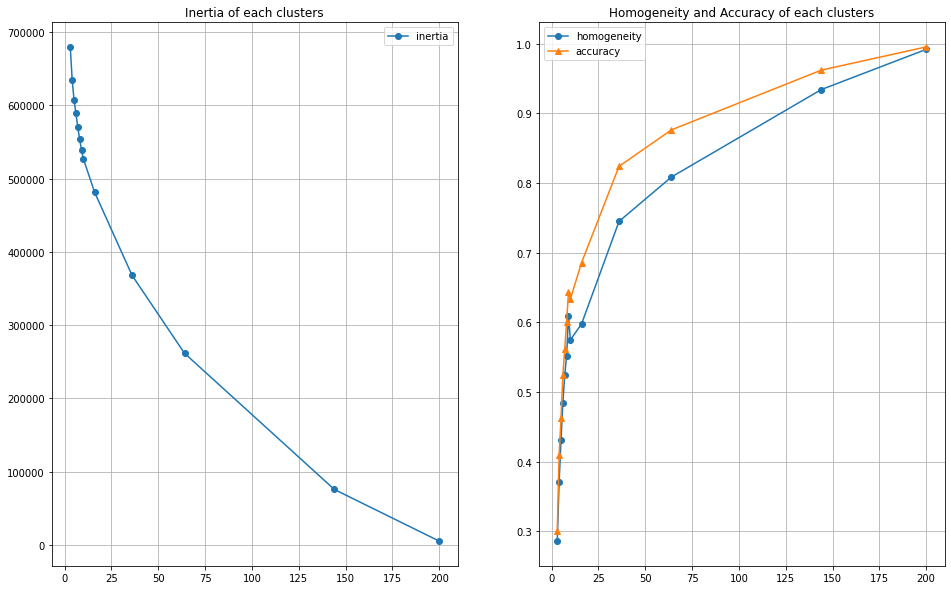

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

In [38]:
!pip install lime

     |████████████████████████████████| 275 kB 6.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a2d41d61db63e1e955abcb789daf438ed6caa1e68adbc0e9b32ec96f8f91c4ed
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [39]:
!pip install shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [40]:
import lime
import lime.lime_tabular
import shap

In [41]:
cluster_labels = infer_cluster_labels(kmeans, label)
prediction = infer_data_labels(kmeans.labels_, cluster_labels)

In [42]:
prediction

array([0, 0, 2, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 7, 7, 1, 0, 0, 6, 0, 2, 4,
       7, 4, 5, 6, 2, 5, 6, 6, 3, 6, 5, 0, 3, 8, 5, 9, 2, 8, 9, 1, 7, 3,
       1, 4, 7, 3, 8, 1, 3, 4, 7, 9, 3, 6, 5, 8, 6, 8, 2, 1, 7, 8, 0, 5,
       6, 3, 6, 4, 9, 7, 9, 1, 5, 3, 6, 6, 8, 3, 1, 4, 3, 9, 8, 5, 2, 4,
       6, 4, 7, 1, 5, 2, 1, 5, 8, 5, 8, 3, 1, 2, 4, 5, 1, 2, 8, 3, 8, 3,
       5, 4, 2, 9, 5, 0, 8, 6, 0, 8, 5, 2, 4, 5, 8, 3, 2, 0, 8, 6, 9, 2,
       8, 4, 5, 8, 0, 6, 2, 4, 9, 4, 5, 5, 2, 7, 8, 4, 9, 3, 2, 4, 2, 5,
       9, 3, 1, 8, 1, 3, 6, 9, 1, 2, 8, 2, 7, 9, 9, 5, 9, 8, 3, 9, 8, 5,
       1, 4, 2, 7, 0, 5, 8, 6, 3, 9, 6, 1, 3, 7, 4, 7, 1, 9, 8, 3, 6, 5,
       6, 4, 1, 3, 8, 5, 4, 6, 0, 4, 6, 1], dtype=uint8)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize


y = label_binarize(prediction, classes=label)
clf=RandomForestClassifier()
clf.fit(x,y)

RandomForestClassifier()

In [44]:
explainer= shap.TreeExplainer(clf)
shap_values = explainer(x).values

In [45]:
shap_values.shape

(210, 150, 420)

In [48]:
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0])

In [47]:
x.shape

(210, 150)